In [1]:
from src.personality import clean_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

In [2]:
raw = pd.read_csv('data/mbti_1 2.csv')

In [3]:
sentences = pipeline_sent(raw)

# Model Selection
- The score to beat would be random which in our case would be 1/16 = 0.0625%, that is too low of a bench mark so we want to aim for above 50%
- Vectorize the text with the following conditions

In [4]:
vectorize = TfidfVectorizer(lowercase=True, stop_words='english',
                            max_features=5000,ngram_range=(1,3))
X = vectorize.fit_transform(sentences.posts)

In [5]:
y = sentences.type

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
rf = RandomForestClassifier(n_estimators=1000,max_depth=5,random_state=29,
                            oob_score=True,n_jobs=-1)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=29, verbose=0, warm_start=False)

In [8]:
rf.oob_score_

0.3614985590778098

- 36% is a good start but not good enough

In [2]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=29)

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

In [11]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.01,
                                 max_depth=3, random_state=29)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=29,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [12]:
gbc.score(X_test,y_test)

0.6457933154053016

- 64.6% is a very nice improvement, let's change our input and keep this model
- Change my vectorizer to not use any stop words and ngrams to 2

In [13]:
vectorize = TfidfVectorizer(lowercase=True, stop_words=None,
                            max_features=5000,ngram_range=(1,2))
X = vectorize.fit_transform(sentences.posts)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=29)

In [15]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.01,
                                 max_depth=5, random_state=29)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=29,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [16]:
gbc.score(X_test,y_test)

0.6273530541682674

In [25]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.01,
                                 max_depth=3, random_state=29)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=29,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [26]:
gbc.score(X_test,y_test)

0.6469458317326162

- Let's remove punctuation and use the Snowball stemmer on our original dataset

In [3]:
clean= pd.read_pickle('data/sentences.pkl')

In [33]:
X = vectorize.fit_transform(clean.posts)
y = clean.type
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=29)

In [34]:
gbc.fit(X_train,y_train)
gbc.score(X_test,y_test)

0.650787552823665

- The additional cleaning got us to 65%

In [35]:
y_pred = gbc.predict(X_test)
check = pd.DataFrame(y_test)
check.reset_index(drop=True,inplace=True)
y_check = pd.Series(y_pred)
check = pd.concat((check,y_check),axis=1)
check.columns = ['y_test','y_pred']
yt= check.groupby('y_test').agg({'y_test':'count'})
yp = check.groupby('y_pred').agg({'y_pred':'count'})
yt.columns = ['count']
yp.columns = ['count']
yt.reset_index(inplace=True)
yp.reset_index(inplace=True)
yt.columns = ['Type','test_count']
yp.columns = ['Type','pred_count']
typecount = pd.merge(yp, yt, on='Type')

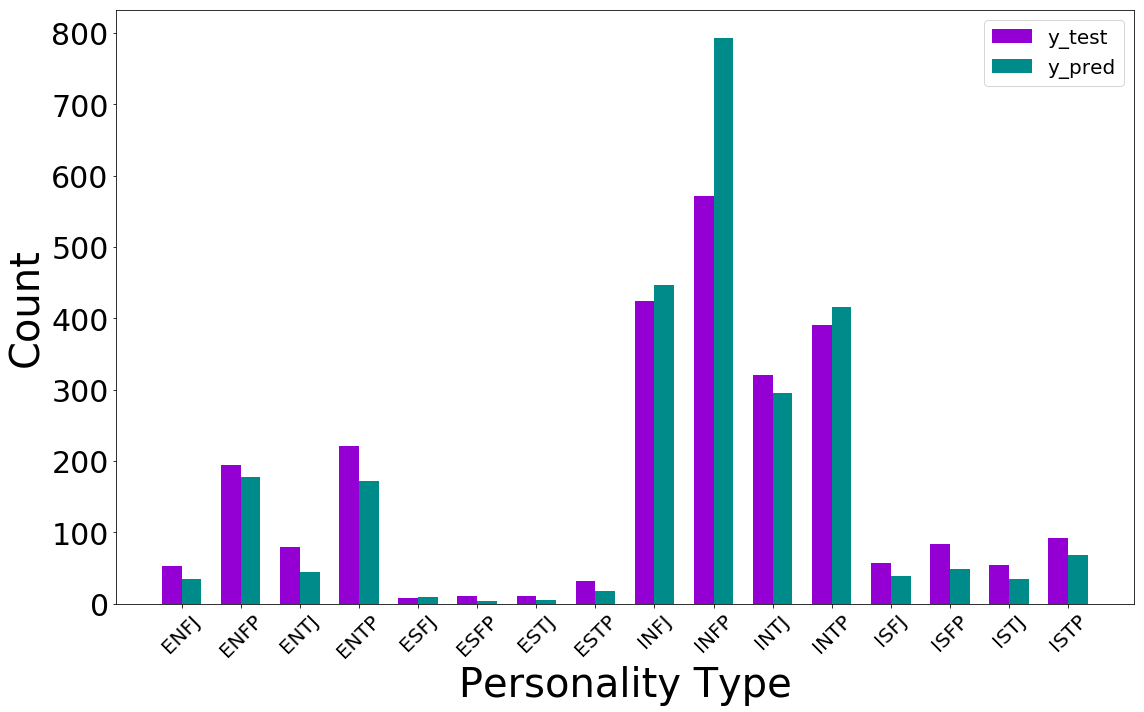

In [36]:
fig, ax1 = plt.subplots(figsize=(16,10))

indices = range(len(typecount.Type))
width = np.min(np.diff(indices))/3.
ax1.set_xlabel('Personality Type',size = 40)
ax1.set_ylabel('Count',size=40)
ax1.bar(indices-width/2.,typecount.test_count,width,color='darkviolet',label='y_test')
ax1.bar(indices+width/2.,typecount.pred_count,width,color='darkcyan',label='y_pred')
ax1.set_xticklabels(typecount.Type.unique())
ax1.tick_params(axis='y')

plt.yticks(size=30)
plt.xticks(range(len(typecount.Type)), rotation=45,size=20)
ax1.legend(prop={'size': 20})
fig.tight_layout()

- Let's switch gears and try an even cleaner data set where we remove stop words.
- In addition, we will print out a summary in order to gauge how our model is performing

In [2]:
sent2 = pd.read_pickle('data/sent2.pkl')
X = sent2.posts
y = sent2.type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 29)

In [6]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

%time
y_pred = nb.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs
accuracy 0.22051479062620052
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        53
        ENFP       0.00      0.00      0.00       195
        ENTJ       0.00      0.00      0.00        80
        ENTP       0.00      0.00      0.00       221
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00        11
        ESTP       0.00      0.00      0.00        32
        INFJ       0.43      0.01      0.01       424
        INFP       0.22      1.00      0.36       571
        INTJ       0.00      0.00      0.00       321
        INTP       0.00      0.00      0.00       391
        ISFJ       0.00      0.00      0.00        57
        ISFP       0.00      0.00      0.00        83
        ISTJ       0.00      0.00      0.00        54
        ISTP       0.00      0.00      0.00 

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [4]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs
accuracy 0.6626968882059162
              precision    recall  f1-score   support

        ENFJ       0.60      0.17      0.26        53
        ENFP       0.65      0.54      0.59       195
        ENTJ       0.80      0.35      0.49        80
        ENTP       0.69      0.56      0.62       221
        ESFJ       0.67      0.25      0.36         8
        ESFP       0.33      0.10      0.15        10
        ESTJ       1.00      0.18      0.31        11
        ESTP       0.90      0.28      0.43        32
        INFJ       0.67      0.72      0.69       424
        INFP       0.64      0.88      0.74       571
        INTJ       0.62      0.67      0.64       321
        INTP       0.69      0.79      0.73       391
        ISFJ       0.74      0.40      0.52        57
        ISFP       0.72      0.31      0.44        83
        ISTJ       0.64      0.33      0.44        54
        ISTP       0.75      0.54      0.63  

In [5]:
import pickle
pickle.dump(sgd,open('sgd.p','wb'))

In [17]:
me = "I think I've learned a lot of information in this class, I can do so much more than when I started this cohort but I know I'm still not at my best. I have a lot to learn and I will put the effort in to get there.that moment when you realize your model predicts the same thing over and over. not a good feeling"
sgd.predict([me])

array(['INTP'], dtype='<U4')

In [83]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs
accuracy 0.6300422589320015
              precision    recall  f1-score   support

        ENFJ       0.69      0.45      0.55        53
        ENFP       0.60      0.59      0.60       195
        ENTJ       0.72      0.42      0.54        80
        ENTP       0.67      0.55      0.60       221
        ESFJ       0.50      0.38      0.43         8
        ESFP       0.50      0.10      0.17        10
        ESTJ       0.40      0.18      0.25        11
        ESTP       0.82      0.28      0.42        32
        INFJ       0.60      0.70      0.65       424
        INFP       0.66      0.78      0.71       571
        INTJ       0.59      0.58      0.58       321
        INTP       0.63      0.71      0.67       391
        ISFJ       0.67      0.46      0.54        57
        ISFP       0.55      0.37      0.45        83
        ISTJ       0.71      0.37      0.49        54
        ISTP       0.63      0.51      0.56

In [85]:
gbc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=.01,
                                 max_depth=3, random_state=29)),
               ])

gbc.fit(X_train,y_train)

%time

y_pred = gbc.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs
accuracy 0.6465616596235113
              precision    recall  f1-score   support

        ENFJ       0.52      0.28      0.37        53
        ENFP       0.64      0.56      0.60       195
        ENTJ       0.77      0.38      0.50        80
        ENTP       0.71      0.53      0.61       221
        ESFJ       0.50      0.38      0.43         8
        ESFP       0.60      0.30      0.40        10
        ESTJ       0.50      0.27      0.35        11
        ESTP       0.67      0.38      0.48        32
        INFJ       0.65      0.72      0.69       424
        INFP       0.61      0.84      0.71       571
        INTJ       0.65      0.59      0.62       321
        INTP       0.68      0.74      0.71       391
        ISFJ       0.57      0.37      0.45        57
        ISFP       0.67      0.42      0.52        83
        ISTJ       0.62      0.48      0.54        54
        ISTP       0.68      0.51      

In [10]:
sgd = Pipeline([('vect', TfidfVectorizer(lowercase=True, stop_words=None,max_features=5000,ngram_range=(1,2))),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
accuracy 0.6699961582789089
              precision    recall  f1-score   support

        ENFJ       0.75      0.17      0.28        53
        ENFP       0.66      0.60      0.63       195
        ENTJ       0.74      0.36      0.49        80
        ENTP       0.70      0.57      0.63       221
        ESFJ       0.67      0.25      0.36         8
        ESFP       0.50      0.10      0.17        10
        ESTJ       1.00      0.09      0.17        11
        ESTP       0.64      0.22      0.33        32
        INFJ       0.65      0.77      0.70       424
        INFP       0.69      0.85      0.76       571
        INTJ       0.66      0.65      0.66       321
        INTP       0.66      0.80      0.72       391
        ISFJ       0.74      0.35      0.48        57
        ISFP       0.66      0.37      0.48        83
        ISTJ       0.76      0.30      0.43        54
        ISTP       0.66      0.57      